In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import tensorflow_datasets as tfds

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch 

**7.- Utilizando redes pre-entrenadas. Gatos vs Perros**

**a.- Preprocesamiento de los datos.**

**Baje los datos provisto por tensorflow.**

**import tensorflow_datasets as tfds**
**El método tfds.load baja y cachea los datos y retorna un objeto tf.data.Dataset.**

**b.- Use subsplit para divider el dataset en (train, validation, test) con 80%, 10%, 10%.**

In [0]:
split = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=split)
(raw_train, raw_validation, raw_test), info = tfds.load('cats_vs_dogs', split=list(splits), with_info=True, as_supervised=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.


**El objeto resultado tf.data.Dataset contiene pares(imagen, label). Donde las imágenes donde las imágenes tienen 3 canales y el label es escalar.**

**Verifique el shape de cada una de las partes (train, validation, test)**

In [0]:
print(raw_train)
print(raw_test)
print(raw_validation)

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


**c.- Muestre las primeras 2 imágenes y etiquetas del train set.**

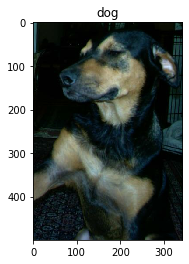

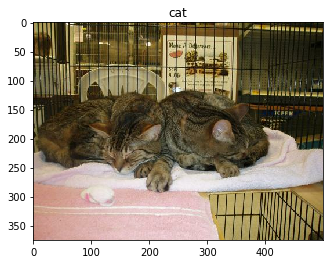

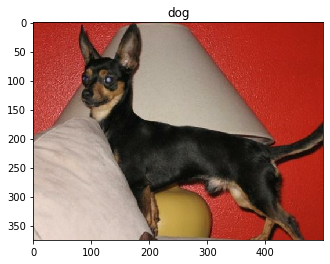

In [0]:
get_label_name = info.features['label'].int2str
for image, label in raw_train.take(3):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

**d..- Formatee los datos: Use el módulo tf.image para formatear las imágenes.**
**Redimensione las imágenes a un tamaño fijo y reescale los canales de entrada al rango [-1,1].**

In [0]:
IMG_SIZE = 160
def format(image, label):
  image = tf.cast(image, tf.float32)
  image = image/255
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [0]:
train = raw_train.map(format)
validation = raw_validation.map(format)
test = raw_test.map(format)

**e.- Reordene aleatoriamente los datos y separe en lotes. Use el siguiente código**

In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)


**Verifique la forma del lote de entrenamiento.**

In [0]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 160, 160, 3])

**f.- Cree el modelo en base a el modelo pre-entrenado MobileNet V2desarrollado por google. Este modelo fue entrenado con 1.4Millones de imágenes y 1000 clases de imágenes de la web. Las clases corresponden a diferentes objetos (autos, casas, etc) pero este base de conocimiento nos ayudará a distinguir los gatos y perros de nuestro dataset específico.**

**Primero, debe elegir qué capa de MobileNet V2 usará para la extracción de features. Obviamente, la última capa de clasificación no es muy útil. En su lugar, seguirá la práctica común para depender de la última capa antes de la operación de aplanar. Esta capa es llamada "el cuello de botella". Los features del cuello de botella conservan mucha generalidad en comparación con la capa final/superior.**

**Instancie el modelo precargado MobileNet V2 con pesos entrenado. Especifique el argumento include_top=False, este permite cargar la red sin incluir las capas de clasificación, lo que es ideal para solo realizar la extracción de features.**

In [0]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [0]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')

9412608/9406464 [==============================] - 2s 0us/step


**Este extractor convierte cada imagen de 160x160x3 a 5x5x1280. Verifique.**

In [0]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


**g.- Congele la base convolucional.**

**Es importante congelar la base convolucional antes de compilar y entrenar el modelo. Para congelar setee (layer.trainable = False), esto previene que los pesos en cada capa  sean actualizados durante el entrenamiento.**

In [0]:
base_model.trainable = False

**h.- utilice el método summary() para ver la estructura de la red.**

In [0]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

**i.- Agregue “la clasificación”.  Para generar predicciones desde el bloque de features  use la capa tf.keras.layers.GlobalAveragePooling2D para convertir los features a un único vector de 1280 elementos por imágen.**

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


**j.- Aplique una capa densa para convertir estos features a una única predicción por imagen. No es necesario una función de activación ya que esta predicción será tratada como un logit o un valor de predicción crudo. (Números + predicen clase 1, Números negativos predicen clase 0)**

In [0]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


**Ahora unimos todo (el extractor de features de la red-preentrenada y las dos capas) en un modelo secuencial de Keras.**

In [0]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

**k.- Debemos compilar el modelo antes de entrenarlo. Ya que solo existen 2 clases usaremos una función de perdida de entropía binaria.**

In [0]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

**Verifique las estructura de nuestra nueva red.**

**¿Cuantos parámetros tiene nuestra Red? ¿Cuántos de estos parámetros serán entrenables? Estos parámetros entrenables ¿de que capa són?**

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


Existen 2 millones de parametros en la primera capa de mobilenetv2, pero se encuentran freezados. Existen 1281 parametros entrenables en la capa densa, provienen de la extrancciond de features de mobilenetv2 y de la capa de pooling.

**l.- Entrene el modelo. Configure 10 épocas. **

In [0]:
num_train, num_val, num_test = (
  info.splits['train'].num_examples*weight/10
  for weight in split
)
initial_epochs = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 20

In [0]:
loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 4s 213ms/step - loss: 5.9156 - accuracy: 0.3875
initial loss: 5.92
initial accuracy: 0.39


In [0]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 98s 169ms/step - loss: 2.5629 - accuracy: 0.6875 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
582/582 [==============================] - 90s 155ms/step - loss: 1.1368 - accuracy: 0.8497 - val_loss: 0.6677 - val_accuracy: 0.9155
Epoch 3/10
582/582 [==============================] - 92s 159ms/step - loss: 0.7858 - accuracy: 0.8921 - val_loss: 0.7214 - val_accuracy: 0.9159
Epoch 4/10
582/582 [==============================] - 92s 158ms/step - loss: 0.6953 - accuracy: 0.9102 - val_loss: 0.6153 - val_accuracy: 0.9267
Epoch 5/10
582/582 [==============================] - 93s 159ms/step - loss: 0.5990 - accuracy: 0.9194 - val_loss: 0.4635 - val_accuracy: 0.9422
Epoch 6/10
582/582 [==============================] - 92s 159ms/step - loss: 0.5579 - accuracy: 0.9268 - val_loss: 0.5224 - val_accuracy: 0.9418
Epoch 7/10
582/582 [==============================] - 92s 158ms/step - loss: 0.5089 - accuracy: 0.9315 - val_loss: 0.5035 

**ll.- Grafique las curvas de entrenamiento del modelo.**

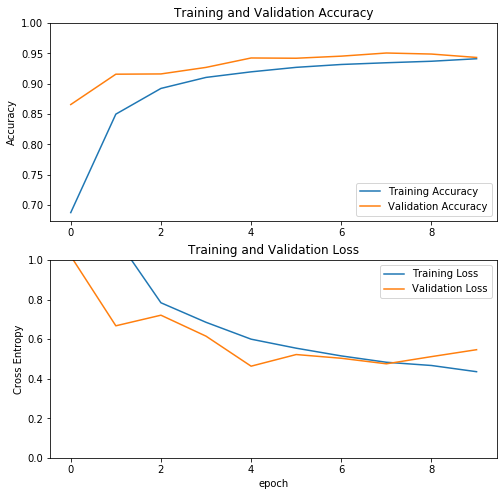

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


**¿Cuál es la precisión del modelo?**

In [0]:
print("Accuracy: {:.5f}".format(acc[-1:][0]))

Accuracy: 0.94098


**m.- Una manera de incrementar la performance es entrenar los pesos de las capas superiores basándose en la capa clasificadora que agregamos.**

**En este caso el entrenamiento forzara a los pesos a actualizarse en base a los features específicos del dataset de perros y gatos en vez de utilizar los pesos de los features genéricos con la cual se entreno la red originalmente.**

**Descongele las capas superiores del modelo.**

In [0]:
base_model.trainable = True

**Verifique cuantas capas tiene el modelo. Congele las primeras 100.**

In [0]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  155


**n.- Recompile el modelo**

**¿Cuántos parámetros tiene la red? ¿Cuántos parámetros son los que hay que entrenar ahora?**

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


**ñ.- Reentrene el modelo. Utilice los mismos parámetros.**

In [0]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 10/20
582/582 [==============================] - 118s 203ms/step - loss: 0.4146 - accuracy: 0.9467 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 11/20
582/582 [==============================] - 108s 186ms/step - loss: 0.3118 - accuracy: 0.9607 - val_loss: 0.2886 - val_accuracy: 0.9651
Epoch 12/20
582/582 [==============================] - 109s 188ms/step - loss: 0.2752 - accuracy: 0.9660 - val_loss: 0.3169 - val_accuracy: 0.9642
Epoch 13/20
582/582 [==============================] - 111s 191ms/step - loss: 0.2477 - accuracy: 0.9708 - val_loss: 0.3038 - val_accuracy: 0.9616
Epoch 14/20
582/582 [==============================] - 111s 190ms/step - loss: 0.2152 - accuracy: 0.9742 - val_loss: 0.2337 - val_accuracy: 0.9711
Epoch 15/20
582/582 [==============================] - 111s 190ms/step - loss: 0.2140 - accuracy: 0.9756 - val_loss: 0.2240 - val_accuracy: 0.9703
Epoch 16/20
582/582 [==============================] - 112s 192ms/step - loss: 0.1618 - accuracy: 0.9808 - val

**o.- Imprima nuevamente las curvas de aprendizaje.**

In [0]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

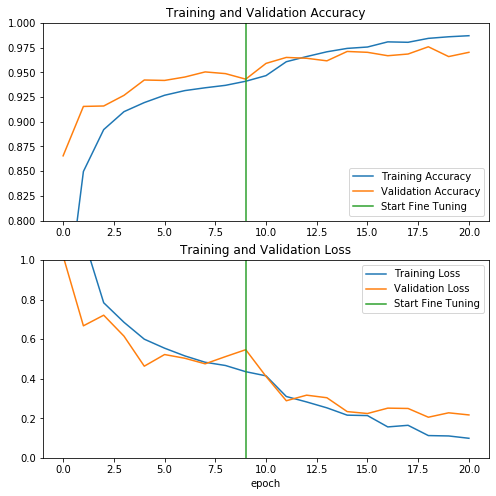

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**p.- ¿Mejora la precisión? ¿Cuánto? ¿Noto algún cambio en los tiempos de entrenamiento?**

In [0]:
print("Accuracy: {:.5f}".format(acc[-1:][0]))

Accuracy: 0.98706


La precision mejora en un 4.5%. En cuanto a los tiempos de entrenamientos estos se incrementan en un principio a casi un 30% mas.